# Vector Quantization

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Audio example of vector quantization with optimized codebooks

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import librosa
import librosa.display
import IPython.display as ipd

Load and display wave file

In [2]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'
#wave_filename = '../audio/E-Core - Pingouin-Banquise_45s.wav'
#wave_filename = '../audio/KIMIKO ISHIZAKA - Goldberg Variations BWV 988 - 01 - Aria_45s.wav'
x, sampling_rate = librosa.load(wave_filename)

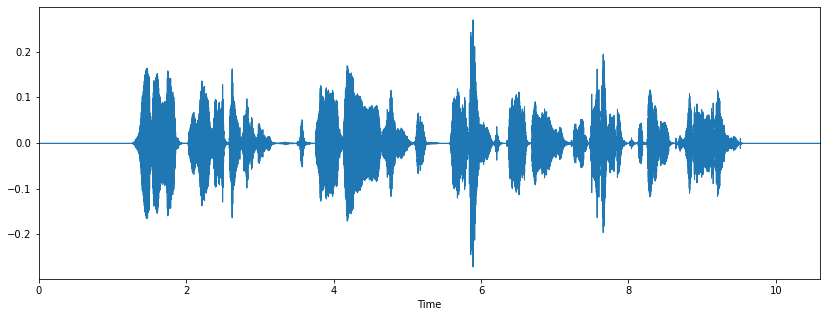

In [3]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sampling_rate)

Play wave file

In [4]:
ipd.Audio(wave_filename) # load a local WAV file

## Uniform Quantization with Midrise Quantizer

In [5]:
w = 4

# fix x_max based on the current signal, leave some room
x_max = np.max([np.max(x), -np.min(x)])
Delta_x = x_max / (2**(w-1))


xh_uniform_midrise = np.sign(x)*Delta_x*(np.floor(np.abs(x)/Delta_x)+0.5) 

# playback quantized audio
ipd.Audio(xh_uniform_midrise, rate=sampling_rate)

(-0.38967272043228146, 0.38967272043228146)

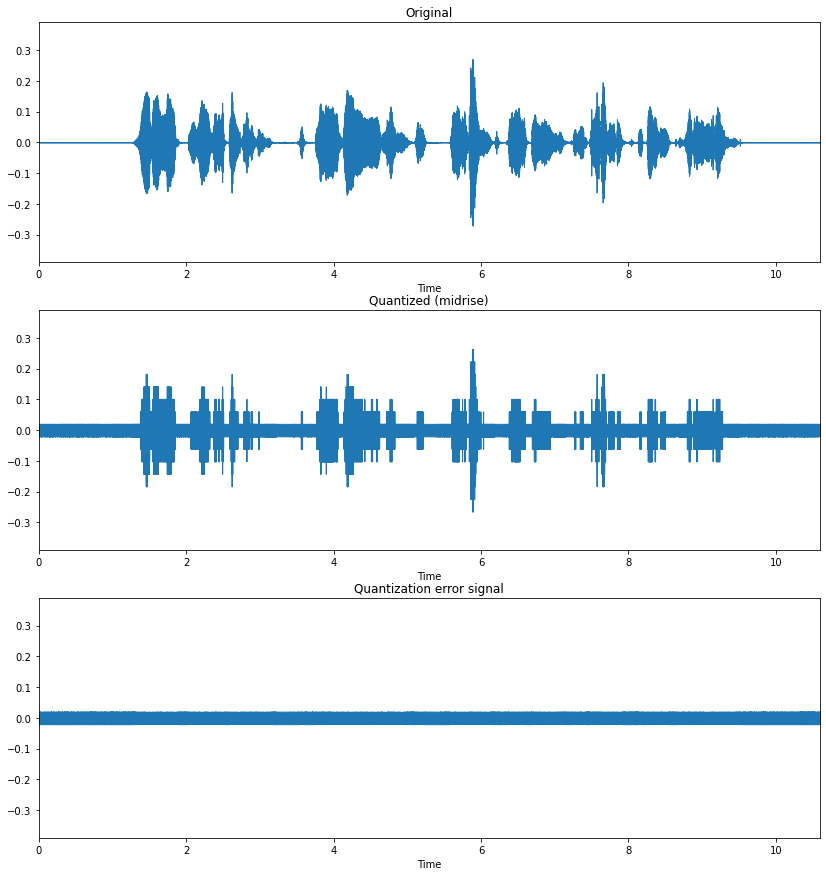

In [6]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveplot(xh_uniform_midrise, sr=sampling_rate)
plt.title('Quantized (midrise)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveplot(x-xh_uniform_midrise, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

## Vector Quantization

In [6]:
def quantize(codebook, x):
    # compute all pairs of distances
    distances = distance.cdist(x, codebook, 'euclidean')

    # find minimum distance
    i_opt = np.argmin(distances, axis=1)
    return i_opt
    
    
# can provide initial codebook, otherwise use random one    
# for simplicity, we only employ algorithm A
def LindeBuzoGray_AlgorithmA(x,K, codebook = []):
    K_T = x.shape[0]
    L = x.shape[1]
    
    max_x = np.amax(x, axis=0)
       
    # random initial codebook
    if len(codebook) == 0:
        codebook = np.random.uniform(-max_x, max_x, (K,L))
    
    old_Dm = -1
    
    print('Generating codebook can take a while ... please wait')
    while True:
        # quantize
        iopt = quantize(codebook,x)
        xh = codebook[iopt]

        # compute average distortion
        Dm = np.mean(np.sum(np.square(x-xh),axis=1))

        if np.abs(Dm-old_Dm)/Dm < 1e-6:
            break
        old_Dm = Dm
        
        # generate new codebook by replacing entries with centroids
        for k in range(K):
            points = np.where(iopt == k)    
            if len(points[0]) > 0:
                codebook[k,:] = np.mean(x[points[0],:], axis=0)
            else:
                # if no point is assigned to the codebook entry, means it will never get changed, we replace it with a random entry
                codebook[k,:] = np.random.uniform(-max_x, max_x, (1,L))

                
    return codebook

In [32]:
# 2-dimensions
L = 2 

#code books size
K = 2**(w*L)

# generate training set
K_T = int(np.floor(len(x)/L))

x_seg = np.reshape(x[0:L*K_T],(K_T,L))
codebook = LindeBuzoGray_AlgorithmA(x_seg, K)

Generating codebook can take a while ... please wait


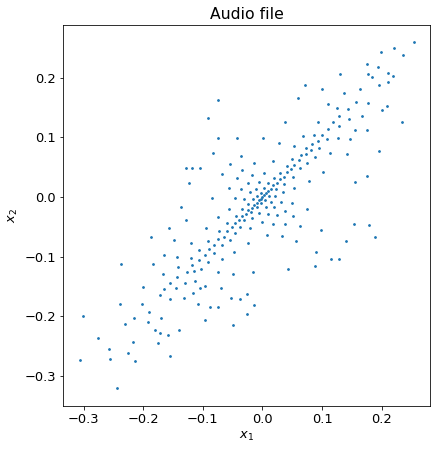

In [33]:
# plot codebook
fig = plt.figure(figsize=(7, 7))
plt.scatter(codebook[:,0], codebook[:,1], s=3)
plt.gca().set_aspect(aspect='equal')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Audio file');

In [34]:
# carry out actual quantization
i_opt = quantize(codebook, x_seg)
xh_vector = np.reshape(codebook[i_opt], L*K_T)

# playback quantized audio
ipd.Audio(xh_vector, rate=sampling_rate)

(-0.38967272043228146, 0.38967272043228146)

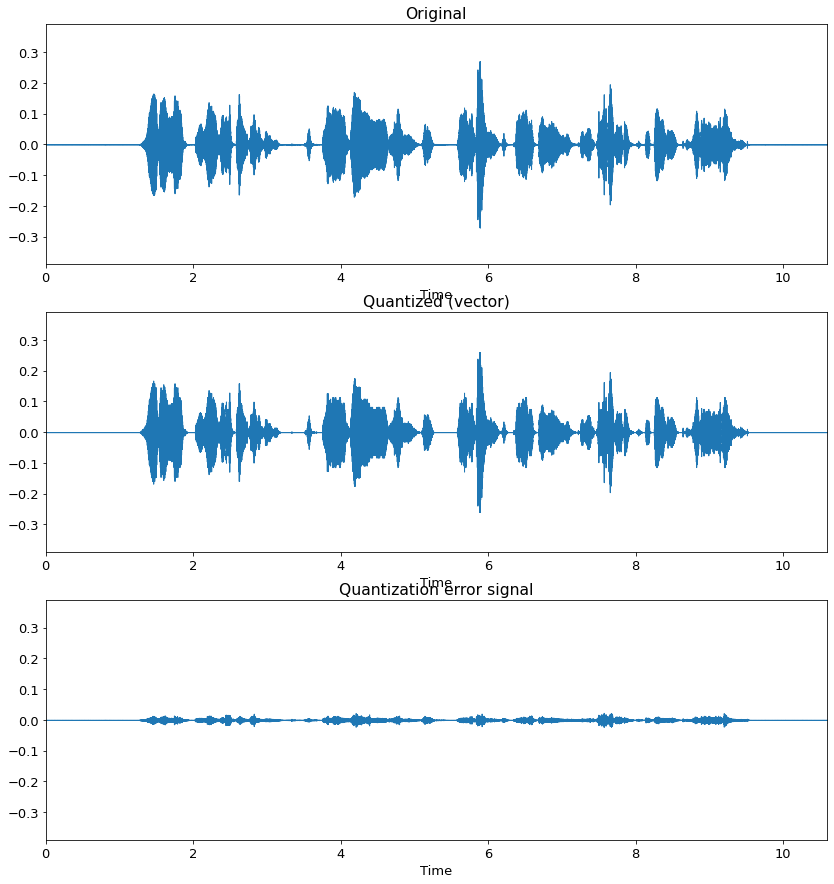

In [35]:
plt.figure(figsize=(14, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,2)
librosa.display.waveplot(xh_vector, sr=sampling_rate)
plt.title('Quantized (vector)')
plt.ylim((-x_max*1.2,+x_max*1.2))
plt.subplot(3,1,3)
librosa.display.waveplot(x[0:L*K_T]-xh_vector, sr=sampling_rate)
plt.title('Quantization error signal')
plt.ylim((-x_max*1.2,+x_max*1.2))

In [36]:
# Compute segmental SNR

# number of samples used for segmentation
seg_len = 256
segments = int(np.floor(len(xh_vector)/seg_len))

x_snr_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))

xh_snr_seg = np.reshape(xh_uniform_midrise[0:segments*seg_len],(segments,seg_len))
snr_scalar_seg = 10*np.log10(np.mean(np.square(x_snr_seg),axis=1) / np.mean(np.square(xh_snr_seg - x_snr_seg),axis=1))

xh_snr_seg = np.reshape(xh_vector[0:segments*seg_len],(segments,seg_len))
snr_vector_seg = 10*np.log10(np.mean(np.square(x_snr_seg),axis=1) / np.mean(np.square(xh_snr_seg - x_snr_seg),axis=1))

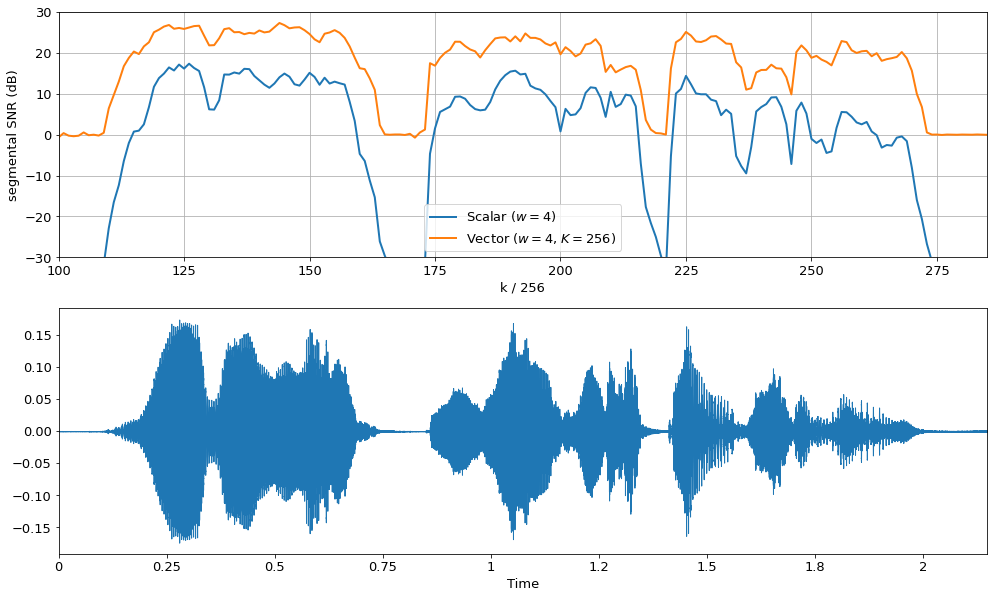

In [37]:
# plot segmental snr
font = {'size'   : 13}
plt.rc('font', **font)
plt.rc('text', usetex=False)

plt.figure(figsize=(14, 8.5))
plt.subplot(2,1,1)
plt.plot(np.arange(segments), snr_scalar_seg, linewidth=2)
plt.plot(np.arange(segments), snr_vector_seg, linewidth=2)
plt.xlabel('k / %d' % seg_len)
plt.ylabel('segmental SNR (dB)')
plt.ylim((-30,30))
plt.grid()

x_start = 25600 // seg_len
x_stop = 72960 // seg_len

plt.xlim((x_start,x_stop))
plt.legend(['Scalar ($w=4$)','Vector ($w=4$, $K=256$)'])

plt.subplot(2,1,2)
librosa.display.waveplot(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

plt.savefig('vector_segmentalSNR_w%d.pdf' % w, bbox_inches='tight')